In [1]:
# ---------------------------------------------------------------------------
# 1) Imports
# ---------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.stats import norm

In [2]:
# Import your modules
import os
os.chdir('/Users/jingyizhang/Desktop/MA4288O/deephedging')

# Import your own modules:
from market.heston import HestonModel
# For the neural net strategies:
from utils.networks import RecurrentHedgeModel, SimpleHedgeModel
# For training loops & loss:
from optimizer.hedge_train import DeepHedgeCVaRTrainer  # or whatever class name you used
# from optimizer.loss_functions import cvar_loss  # if needed for direct calls
from payoff.european_option import european_call_payoff  # <-- IMPORTANT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# ---------------------------------------------------------------------------
# 2) Optional: Model Hedge (e.g. Black-Scholes) function
# ---------------------------------------------------------------------------
def black_scholes_call_price_delta(S0, K, T, sigma):
    """
    For r=0. Returns (price, delta).
    """
    d1 = (np.log(S0/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    price = S0*norm.cdf(d1) - K*norm.cdf(d2)
    delta = norm.cdf(d1)
    return price, delta

def compute_model_hedge_pnl(q, Z, delta_const, S_paths):
    """
    frictionless PnL = q - Z + delta_const * sum_{k=0}^{n-1} [S_{k+1}-S_k].
    """
    S_diff = S_paths[:,1:] - S_paths[:,:-1]  # shape (n_paths, n_steps)
    gains = delta_const * np.sum(S_diff, axis=1)
    pnl = q - Z + gains
    return pnl

In [4]:
# ----------------------------------------------------------------------------
# 3) Simulation Setup
# ----------------------------------------------------------------------------
num_paths = 200_000
num_steps = 30
T = 30/365  # 30 days

heston = HestonModel(
    s0=100.0,
    v0=0.04,
    kappa=1.5,
    theta=0.04,
    xi=0.5,
    rho=-0.7,
    r=0.0,
    dt=T/num_steps,
    seed=1234
)

S_paths_np, V_paths_np = heston.simulate_paths(n_paths=num_paths, n_steps=num_steps)
print("Simulated S_paths shape:", S_paths_np.shape)

K = 100.0
Z_np = european_call_payoff(S_paths_np, K=K)  # <-- NO MORE NameError
print("Payoff shape:", Z_np.shape)

# Convert to torch
S_torch = torch.from_numpy(S_paths_np).float().to(device)
Z_torch = torch.from_numpy(Z_np).float().to(device)

Simulated S_paths shape: (200000, 31)
Payoff shape: (200000,)


In [5]:
# ----------------------------------------------------------------------------
# 4) Model Hedge
# ----------------------------------------------------------------------------
sigma_guess = 0.2
q_bs, delta_bs = black_scholes_call_price_delta(S0=100.0, K=K, T=T, sigma=sigma_guess)
model_pnl = compute_model_hedge_pnl(q_bs, Z_np, delta_bs, S_paths_np)
print("Model Hedge Stats:")
print("  mean PnL =", model_pnl.mean())
print("  std PnL  =", model_pnl.std())

Model Hedge Stats:
  mean PnL = 0.04533853082149925
  std PnL  = 1.7444771163482315


In [6]:
# ----------------------------------------------------------------------------
# 5) Train Recurrent Hedge under CVaR alpha=0.5
# ----------------------------------------------------------------------------
alpha = 0.5
recurrent_model = RecurrentHedgeModel(steps=num_steps, in_dim=2, hidden_dim=32, out_dim=1).to(device)
trainer_rec = DeepHedgeCVaRTrainer(recurrent_model, alpha=alpha, lr=1e-3)
p0_rec = trainer_rec.train(
    S_tensor=S_torch,
    Z_tensor=Z_torch,
    p0_init=q_bs,
    n_epochs=5,
    batch_size=4096
)
print(f"Recurrent Hedge Price p0_rec = {p0_rec:.4f}")

with torch.no_grad():
    deltas_rec = recurrent_model(S_torch)
    Sdiff = S_torch[:,1:] - S_torch[:,:-1]
    gains_rec = torch.sum(deltas_rec * Sdiff, dim=1)
    pnl_rec = (trainer_rec.p0 - Z_torch + gains_rec).cpu().numpy()

Epoch 1/5 | CVaR loss: 3.2338, w=-0.1577, p0=2.3362
Epoch 2/5 | CVaR loss: 1.1898, w=-0.4277, p0=2.3852
Epoch 3/5 | CVaR loss: 1.1026, w=-0.4711, p0=2.4342
Epoch 4/5 | CVaR loss: 1.0680, w=-0.5117, p0=2.4832
Epoch 5/5 | CVaR loss: 1.0275, w=-0.5448, p0=2.5322
Recurrent Hedge Price p0_rec = 2.5322


In [7]:
# ----------------------------------------------------------------------------
# 6) Train Simpler Hedge under CVaR alpha=0.5
# ----------------------------------------------------------------------------
simple_model = SimpleHedgeModel(steps=num_steps, hidden_dim=16).to(device)
trainer_simp = DeepHedgeCVaRTrainer(simple_model, alpha=alpha, lr=1e-3)
p0_simp = trainer_simp.train(
    S_tensor=S_torch,
    Z_tensor=Z_torch,
    p0_init=q_bs,
    n_epochs=5,
    batch_size=4096
)
print(f"Simple Hedge Price p0_simp = {p0_simp:.4f}")

with torch.no_grad():
    deltas_simp = simple_model(S_torch)
    Sdiff_simp = S_torch[:,1:] - S_torch[:,:-1]
    gains_simp = torch.sum(deltas_simp * Sdiff_simp, dim=1)
    pnl_simp = (trainer_simp.p0 - Z_torch + gains_simp).cpu().numpy()

Epoch 1/5 | CVaR loss: 1.1912, w=-0.4717, p0=2.3362
Epoch 2/5 | CVaR loss: 1.1215, w=-0.4402, p0=2.3852
Epoch 3/5 | CVaR loss: 1.0697, w=-0.4934, p0=2.4342
Epoch 4/5 | CVaR loss: 1.0202, w=-0.5386, p0=2.4832
Epoch 5/5 | CVaR loss: 0.9691, w=-0.5972, p0=2.5322
Simple Hedge Price p0_simp = 2.5322


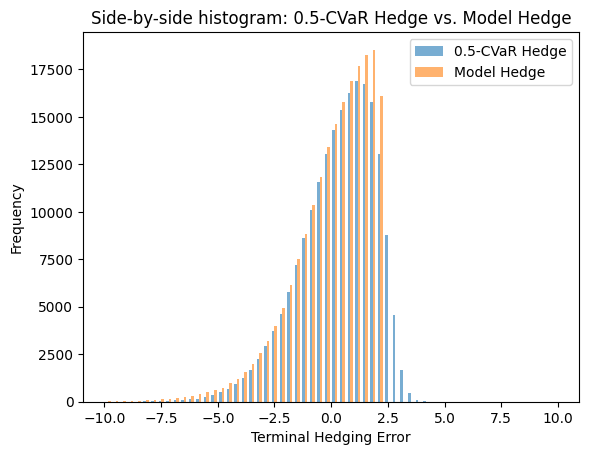

In [8]:
# ----------------------------------------------------------------------------
# 7) Figures
# ----------------------------------------------------------------------------

def plot_side_by_side_hist(pnl1, pnl2, label1="CVaR Hedge", label2="Model Hedge",
                           bins=50, range=(-10,10)):
    """
    Plot side-by-side histogram bars for two PnL arrays, over the same bins.
    
    Args:
      pnl1, pnl2: 1D arrays of data.
      label1, label2: legend labels for the two sets of bars.
      bins: int or sequence of bin edges
      range: (min, max) range for the histogram
    """
    # 1) Manually compute hist counts for each distribution
    counts1, edges = np.histogram(pnl1, bins=bins, range=range)
    counts2, _     = np.histogram(pnl2, bins=edges)  # use same edges for second data
    
    # 2) Convert counts to frequency or density, if desired (optional)
    # e.g. to show frequencies, we can keep as is, or for probability densities:
    # step = edges[1] - edges[0]
    # counts1 = counts1 / (counts1.sum() * step)
    # counts2 = counts2 / (counts2.sum() * step)
    
    # 3) The bin centers
    centers = 0.5 * (edges[:-1] + edges[1:])
    width   = (edges[1] - edges[0]) / 3.0  # bar width is 1/3 of bin width
                                          # so the two bars can fit side by side
    
    # 4) Shift one bar group left, the other right
    plt.bar(
        centers - width/2, counts1, width=width,
        alpha=0.6, label=label1, color='tab:blue'
    )
    plt.bar(
        centers + width/2, counts2, width=width,
        alpha=0.6, label=label2, color='tab:orange'
    )
    
    # 5) Label and show
    plt.xlabel("Terminal Hedging Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Side-by-side histogram: {label1} vs. {label2}")
    plt.show()

plot_side_by_side_hist(pnl_rec, model_pnl,
                       label1="0.5-CVaR Hedge", label2="Model Hedge",
                       bins=60, range=(-10,10))


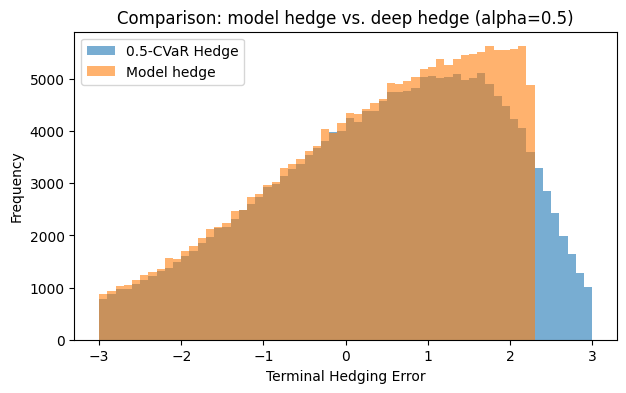

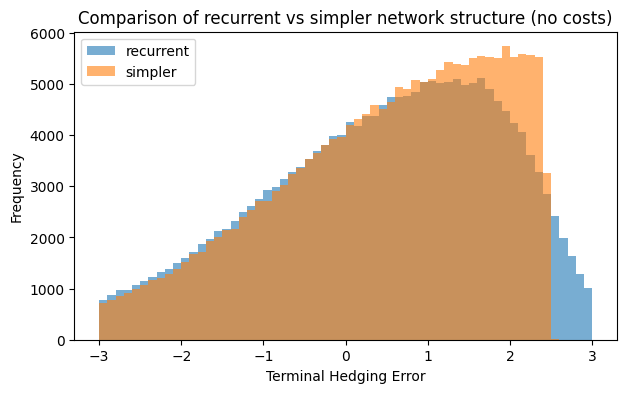

In [9]:
# ----------------------------------------------------------------------------
# 7) Figures (Updated for style)
# ----------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Figure 2-style: Model Hedge vs. Deep Hedge
plt.figure(figsize=(7,4))
plt.hist(
    pnl_rec, bins=60, alpha=0.6, label='0.5-CVaR Hedge',
    color='tab:blue', range=(-3,3)  # adjust range as needed
)
plt.hist(
    model_pnl, bins=60, alpha=0.6, label='Model hedge',
    color='tab:orange', range=(-3,3)
)
plt.title('Comparison: model hedge vs. deep hedge (alpha=0.5)')
plt.xlabel('Terminal Hedging Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Figure 4-style: Recurrent vs. Simpler
plt.figure(figsize=(7,4))
plt.hist(
    pnl_rec, bins=60, alpha=0.6, label='recurrent',
    color='tab:blue', range=(-3,3)
)
plt.hist(
    pnl_simp, bins=60, alpha=0.6, label='simpler',
    color='tab:orange', range=(-3,3)
)
plt.title('Comparison of recurrent vs simpler network structure (no costs)')
plt.xlabel('Terminal Hedging Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [10]:
# ----------------------------------------------------------------------------
# 8) Numeric Table (Mean Loss, Price, Realized CVaR)
# ----------------------------------------------------------------------------
def empirical_cvar(x, alpha=0.99):
    x_sorted = np.sort(x)
    cutoff = int(len(x)*(1-alpha))
    if cutoff <= 0:
        return x_sorted[0]
    tail = x_sorted[:cutoff]
    return tail.mean()

alpha_cvar = 0.99

mean_rec = pnl_rec.mean()
real_cvar_rec = empirical_cvar(pnl_rec, alpha=alpha_cvar)

mean_simp = pnl_simp.mean()
real_cvar_simp = empirical_cvar(pnl_simp, alpha=alpha_cvar)

print("\n===== Architecture Comparison Table =====")
print("Architecture | Mean Loss |   Price   | Realized CVaR(99%)")
print("---------------------------------------------------------")
print(f"Recurrent    | {mean_rec:.4f}   | {p0_rec:.4f} | {real_cvar_rec:.4f}")
print(f"Simpler      | {mean_simp:.4f}   | {p0_simp:.4f} | {real_cvar_simp:.4f}")


===== Architecture Comparison Table =====
Architecture | Mean Loss |   Price   | Realized CVaR(99%)
---------------------------------------------------------
Recurrent    | 0.2903   | 2.5322 | -5.4756
Simpler      | 0.2903   | 2.5322 | -5.6881


In [17]:
# ----------------------------------------------------------------------------
# 8) Numeric Table (Mean Loss, Price, Realized CVaR) [UPDATED]
# ----------------------------------------------------------------------------
def empirical_cvar(x, alpha=0.99):
    x_sorted = np.sort(x)
    cutoff = int(len(x)*(1-alpha))
    if cutoff <= 0:
        return x_sorted[0]
    tail = x_sorted[:cutoff]
    return tail.mean()

alpha_cvar = 0.99

mean_rec = pnl_rec.mean()
real_cvar_rec = empirical_cvar(pnl_rec, alpha=alpha_cvar)

mean_simp = pnl_simp.mean()
real_cvar_simp = empirical_cvar(pnl_simp, alpha=alpha_cvar)

# >>>>>>>>>>>>>>>> NEW LINES: NORMALIZE BY q_bs <<<<<<<<<<<<<<<
pnl_rec_norm = pnl_rec / q_bs
pnl_simp_norm = pnl_simp / q_bs

mean_rec_norm = pnl_rec_norm.mean()
real_cvar_rec_norm = empirical_cvar(pnl_rec_norm, alpha=alpha_cvar)

mean_simp_norm = pnl_simp_norm.mean()
real_cvar_simp_norm = empirical_cvar(pnl_simp_norm, alpha=alpha_cvar)
# >>>>>>>>>>>>>>>> END NEW LINES <<<<<<<<<<<<<<<

print("\n===== Architecture Comparison Table =====")
print("Architecture |  Mean Loss (abs)  |  Price   | CVaR(99%) (abs)")
print("--------------------------------------------------------------")
print(f"Recurrent    | {mean_rec:.4f}             | {p0_rec:.4f}    | {real_cvar_rec:.4f}")
print(f"Simpler      | {mean_simp:.4f}             | {p0_simp:.4f}    | {real_cvar_simp:.4f}")

# >>>>>>>>>>>>>>>> NEW LINES: PRINT NORMALIZED RESULTS <<<<<<<<<<<<<<<
print("\n===== Normalized by Risk-Neutral Price (q_bs) =====")
print(f"q_bs = {q_bs:.4f}")
print("Architecture | Mean Loss / q_bs | CVaR(99%) / q_bs")
print("-------------------------------------------------")
print(f"Recurrent    | {mean_rec_norm:.4f}          | {real_cvar_rec_norm:.4f}")
print(f"Simpler      | {mean_simp_norm:.4f}          | {real_cvar_simp_norm:.4f}")
# >>>>>>>>>>>>>>>> END NEW LINES <<<<<<<<<<<<<<<


===== Architecture Comparison Table =====
Architecture |  Mean Loss (abs)  |  Price   | CVaR(99%) (abs)
--------------------------------------------------------------
Recurrent    | 0.2903             | 2.5322    | -5.4756
Simpler      | 0.2903             | 2.5322    | -5.6881

===== Normalized by Risk-Neutral Price (q_bs) =====
q_bs = 2.2872
Architecture | Mean Loss / q_bs | CVaR(99%) / q_bs
-------------------------------------------------
Recurrent    | 0.1269          | -2.3941
Simpler      | 0.1269          | -2.4870


Epoch 1/5 | Loss: 2705.1253 | p0: 2.3362
Epoch 2/5 | Loss: 1583.4175 | p0: 2.3852
Epoch 3/5 | Loss: 966.9456 | p0: 2.4342
Epoch 4/5 | Loss: 614.9231 | p0: 2.4832
Epoch 5/5 | Loss: 526.0064 | p0: 2.5322
Epoch 1/5 | Loss: 8.7088 | p0: 2.3362
Epoch 2/5 | Loss: 1.2232 | p0: 2.3852
Epoch 3/5 | Loss: 1.0974 | p0: 2.4342
Epoch 4/5 | Loss: 1.1322 | p0: 2.4832
Epoch 5/5 | Loss: 1.0714 | p0: 2.5322


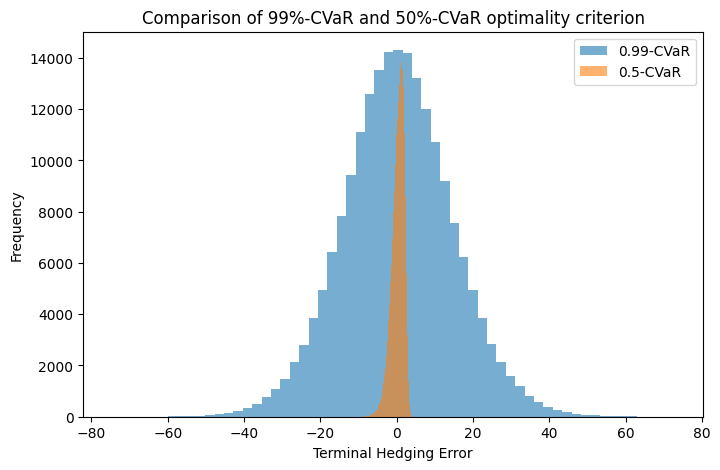


=== Comparison of 99%-CVaR and 50%-CVaR strategies ===
Trained with 99%-CVaR => p0_099 = 2.5322
  Mean Loss = 0.2812, Realized 0.5-CVaR = -10.9390, Realized 0.99-CVaR = -39.3946

Trained with 50%-CVaR => p0_05  = 2.5322
  Mean Loss = 0.2907,  Realized 0.5-CVaR = -1.0274, Realized 0.99-CVaR = -5.5866


In [15]:
###############################################################################
# Additional code snippet for comparing 0.99-CVaR vs 0.5-CVaR
###############################################################################

# 1) Train a deep hedge with alpha=0.99
model_099 = RecurrentHedgeModel(steps=num_steps, in_dim=2, hidden_dim=32, out_dim=1).to(device)
trainer_099 = DeepHedgeCVaRTrainer(model_099, alpha=0.99, lr=1e-3)
p0_099 = trainer_099.train(
    S_tensor=S_torch,
    Z_tensor=Z_torch,
    p0_init=q_bs,     # or 0.0 if you prefer
    n_epochs=5,
    batch_size=4096
)

# Evaluate final distribution of hedging errors
with torch.no_grad():
    deltas_099 = model_099(S_torch)
    Sdiff_099 = S_torch[:, 1:] - S_torch[:, :-1]
    gains_099 = torch.sum(deltas_099 * Sdiff_099, dim=1)
    pnl_099_torch = (trainer_099.p0 - Z_torch + gains_099)
pnl_099 = pnl_099_torch.cpu().numpy()

# 2) Train a deep hedge with alpha=0.5
model_05 = RecurrentHedgeModel(steps=num_steps, in_dim=2, hidden_dim=32, out_dim=1).to(device)
trainer_05 = DeepHedgeCVaRTrainer(model_05, alpha=0.5, lr=1e-3)
p0_05 = trainer_05.train(
    S_tensor=S_torch,
    Z_tensor=Z_torch,
    p0_init=q_bs,
    n_epochs=5,
    batch_size=4096
)

# Evaluate final distribution
with torch.no_grad():
    deltas_05 = model_05(S_torch)
    Sdiff_05 = S_torch[:, 1:] - S_torch[:, :-1]
    gains_05 = torch.sum(deltas_05 * Sdiff_05, dim=1)
    pnl_05_torch = (trainer_05.p0 - Z_torch + gains_05)
pnl_05 = pnl_05_torch.cpu().numpy()

# 3) Plot histograms side by side (like Figure 6)
plt.figure(figsize=(8,5))
plt.hist(pnl_099, bins=60, alpha=0.6, label='0.99-CVaR', color='tab:blue')
plt.hist(pnl_05,  bins=60, alpha=0.6, label='0.5-CVaR', color='tab:orange')
plt.title('Comparison of 99%-CVaR and 50%-CVaR optimality criterion')
plt.xlabel('Terminal Hedging Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 4) Create the numeric table (like Figure 7)
# We'll compute mean loss and realized CVaR at both alpha=0.5 and alpha=0.99
mean_099 = pnl_099.mean()
rcvar_05_099 = empirical_cvar(pnl_099, alpha=0.5)
rcvar_99_099 = empirical_cvar(pnl_099, alpha=0.99)

mean_05 = pnl_05.mean()
rcvar_05_05 = empirical_cvar(pnl_05, alpha=0.5)
rcvar_99_05 = empirical_cvar(pnl_05, alpha=0.99)

print("\n=== Comparison of 99%-CVaR and 50%-CVaR strategies ===")
print("Trained with 99%-CVaR => p0_099 = {:.4f}".format(p0_099))
print(f"  Mean Loss = {mean_099:.4f}, Realized 0.5-CVaR = {rcvar_05_099:.4f}, Realized 0.99-CVaR = {rcvar_99_099:.4f}")
print("")
print("Trained with 50%-CVaR => p0_05  = {:.4f}".format(p0_05))
print(f"  Mean Loss = {mean_05:.4f},  Realized 0.5-CVaR = {rcvar_05_05:.4f}, Realized 0.99-CVaR = {rcvar_99_05:.4f}")


In [18]:
###############################################################################
# (EXTRA CELL) -  99% CVaR vs. 50% CVaR: Final Table with Normalization
###############################################################################

# We'll assume you have:
#   pnl_099, p0_099 (trained with alpha=0.99)
#   pnl_05,  p0_05  (trained with alpha=0.5)
#   q_bs     (risk-neutral price from e.g. black_scholes_call_price_delta)

def empirical_cvar(x, alpha=0.99):
    x_sorted = np.sort(x)
    cutoff = int(len(x)*(1-alpha))
    if cutoff <= 0:
        return x_sorted[0]
    tail = x_sorted[:cutoff]
    return tail.mean()

# 1) Absolute metrics
mean_099 = pnl_099.mean()
cvar_05_099 = empirical_cvar(pnl_099, alpha=0.5)
cvar_99_099 = empirical_cvar(pnl_099, alpha=0.99)

mean_05 = pnl_05.mean()
cvar_05_05 = empirical_cvar(pnl_05, alpha=0.5)
cvar_99_05 = empirical_cvar(pnl_05, alpha=0.99)

# >>>>>>> NEW LINES: NORMALIZE PNL BY q_bs <<<<<<<
pnl_099_norm = pnl_099 / q_bs
pnl_05_norm  = pnl_05  / q_bs

mean_099_norm = pnl_099_norm.mean()
cvar_05_099_norm = empirical_cvar(pnl_099_norm, alpha=0.5)
cvar_99_099_norm = empirical_cvar(pnl_099_norm, alpha=0.99)

mean_05_norm = pnl_05_norm.mean()
cvar_05_05_norm = empirical_cvar(pnl_05_norm, alpha=0.5)
cvar_99_05_norm = empirical_cvar(pnl_05_norm, alpha=0.99)
# >>>>>>> END NEW LINES <<<<<<<

# 2) Print Table
print("===== Comparison of alpha=0.99 vs alpha=0.5 (Absolute) =====")
print(f"Trained with CVaR(0.99): p0_099 = {p0_099:.4f}")
print(f"   Mean PnL     = {mean_099:.4f}")
print(f"   CVaR(0.5)    = {cvar_05_099:.4f}")
print(f"   CVaR(0.99)   = {cvar_99_099:.4f}\n")

print(f"Trained with CVaR(0.50): p0_05  = {p0_05:.4f}")
print(f"   Mean PnL     = {mean_05:.4f}")
print(f"   CVaR(0.5)    = {cvar_05_05:.4f}")
print(f"   CVaR(0.99)   = {cvar_99_05:.4f}")

# >>>>>>> NEW LINES: PRINT NORMALIZED METRICS <<<<<<<
print("\n===== Normalized by Risk-Neutral Price (q_bs) =====")
print(f"Risk-neutral price q_bs = {q_bs:.4f}\n")

print(f"[CVaR(0.99) Strategy]   Mean PnL / q_bs   = {mean_099_norm:.4f}")
print(f"                       CVaR(0.5) / q_bs   = {cvar_05_099_norm:.4f}")
print(f"                       CVaR(0.99) / q_bs  = {cvar_99_099_norm:.4f}\n")

print(f"[CVaR(0.50) Strategy]   Mean PnL / q_bs   = {mean_05_norm:.4f}")
print(f"                       CVaR(0.5) / q_bs   = {cvar_05_05_norm:.4f}")
print(f"                       CVaR(0.99) / q_bs  = {cvar_99_05_norm:.4f}")
# >>>>>>> END NEW LINES <<<<<<<


===== Comparison of alpha=0.99 vs alpha=0.5 (Absolute) =====
Trained with CVaR(0.99): p0_099 = 2.5322
   Mean PnL     = 0.2812
   CVaR(0.5)    = -10.9390
   CVaR(0.99)   = -39.3946

Trained with CVaR(0.50): p0_05  = 2.5322
   Mean PnL     = 0.2907
   CVaR(0.5)    = -1.0274
   CVaR(0.99)   = -5.5866

===== Normalized by Risk-Neutral Price (q_bs) =====
Risk-neutral price q_bs = 2.2872

[CVaR(0.99) Strategy]   Mean PnL / q_bs   = 0.1230
                       CVaR(0.5) / q_bs   = -4.7828
                       CVaR(0.99) / q_bs  = -17.2243

[CVaR(0.50) Strategy]   Mean PnL / q_bs   = 0.1271
                       CVaR(0.5) / q_bs   = -0.4492
                       CVaR(0.99) / q_bs  = -2.4426


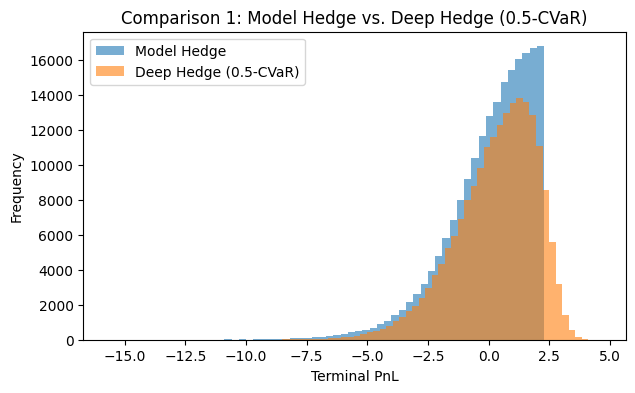


===== Comparison: ModelH vs. DeepH-0.5 =====
Strategy    |    Mean    |  CVaR(50%)  |  CVaR(99%) 
--------------------------------------------------
ModelH      |     0.0453 |    -1.2825 |    -6.9360
DeepH-0.5   |     0.2907 |    -1.0274 |    -5.5866


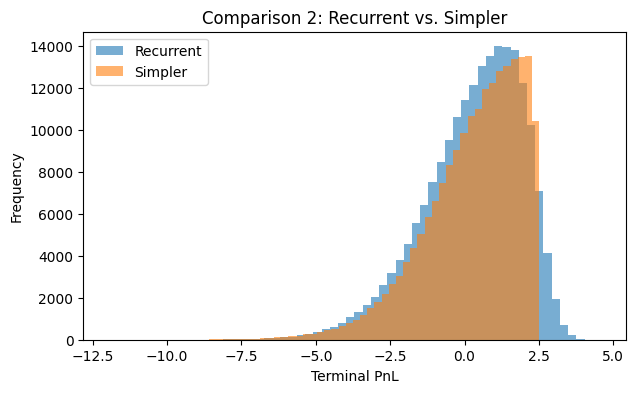


===== Comparison: Recurrent vs. Simpler =====
Strategy    |    Mean    |  CVaR(50%)  |  CVaR(99%) 
--------------------------------------------------
Recurrent   |     0.2903 |    -1.0275 |    -5.4756
Simpler     |     0.2903 |    -0.9691 |    -5.6881


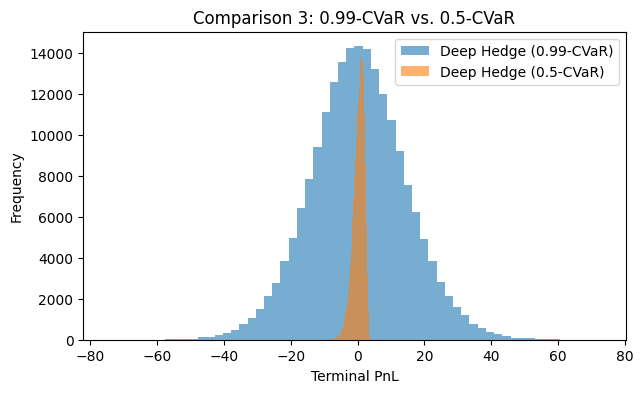


===== Comparison: DH-0.99 vs. DH-0.50 =====
Strategy    |    Mean    |  CVaR(50%)  |  CVaR(99%) 
--------------------------------------------------
DH-0.99     |     0.2812 |   -10.9390 |   -39.3946
DH-0.50     |     0.2907 |    -1.0274 |    -5.5866


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose these are your final PnL arrays (1D numpy arrays), e.g.:
#   model_pnl   -> from a black-scholes "model hedge"
#   pnl_05      -> from deep hedge with alpha=0.5
#   pnl_rec     -> from "recurrent" approach
#   pnl_simp    -> from "simpler" approach
#   pnl_099     -> from deep hedge with alpha=0.99
#
# Already available in your code:
#   model_pnl, pnl_05, pnl_rec, pnl_simp, pnl_099

def empirical_cvar(x, alpha=0.99):
    x_sorted = np.sort(x)
    cutoff = int(len(x)*(1-alpha))
    if cutoff <= 0:
        return x_sorted[0]
    tail = x_sorted[:cutoff]
    return tail.mean()

def print_stats_comparison(pnl_a, label_a, pnl_b, label_b):
    """
    Prints mean, CVaR(50%), CVaR(99%) for two arrays side by side.
    """
    # Stats for A
    meanA = pnl_a.mean()
    cvar50A = empirical_cvar(pnl_a, alpha=0.50)
    cvar99A = empirical_cvar(pnl_a, alpha=0.99)

    # Stats for B
    meanB = pnl_b.mean()
    cvar50B = empirical_cvar(pnl_b, alpha=0.50)
    cvar99B = empirical_cvar(pnl_b, alpha=0.99)

    print(f"\n===== Comparison: {label_a} vs. {label_b} =====")
    print("Strategy    |    Mean    |  CVaR(50%)  |  CVaR(99%) ")
    print("--------------------------------------------------")
    print(f"{label_a:<12}| {meanA:10.4f} | {cvar50A:10.4f} | {cvar99A:10.4f}")
    print(f"{label_b:<12}| {meanB:10.4f} | {cvar50B:10.4f} | {cvar99B:10.4f}")

def plot_hist_comparison(pnl_a, label_a, pnl_b, label_b, title="Comparison"):
    """
    Overlays two histograms with different colors & legends.
    """
    plt.figure(figsize=(7,4))
    plt.hist(pnl_a, bins=60, alpha=0.6, label=label_a, color='tab:blue')
    plt.hist(pnl_b, bins=60, alpha=0.6, label=label_b, color='tab:orange')
    plt.title(title)
    plt.xlabel('Terminal PnL')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


###############################################################################
# 1) Model Hedge vs Deep Hedge (e.g. alpha=0.5)
###############################################################################
plot_hist_comparison(
    model_pnl, "Model Hedge",
    pnl_05,    "Deep Hedge (0.5-CVaR)",
    title="Comparison 1: Model Hedge vs. Deep Hedge (0.5-CVaR)"
)
print_stats_comparison(model_pnl, "ModelH", pnl_05, "DeepH-0.5")


###############################################################################
# 2) Recurrent vs Simpler
###############################################################################
plot_hist_comparison(
    pnl_rec, "Recurrent",
    pnl_simp, "Simpler",
    title="Comparison 2: Recurrent vs. Simpler"
)
print_stats_comparison(pnl_rec, "Recurrent", pnl_simp, "Simpler")


###############################################################################
# 3) 99 vs 50
###############################################################################
plot_hist_comparison(
    pnl_099, "Deep Hedge (0.99-CVaR)",
    pnl_05,  "Deep Hedge (0.5-CVaR)",
    title="Comparison 3: 0.99-CVaR vs. 0.5-CVaR"
)
print_stats_comparison(pnl_099, "DH-0.99", pnl_05, "DH-0.50")

In [25]:
len(pnl_099), len(pnl_05), len(pnl_rec), len(pnl_simp), len(model_pnl)

(200000, 200000, 200000, 200000, 200000)

Total samples in pnl_099: 200000
Total samples in pnl_05: 200000


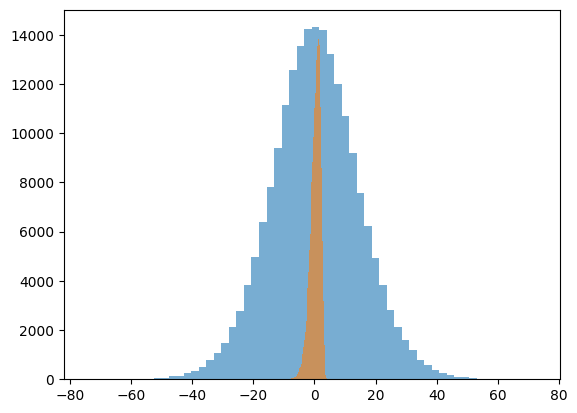

In [31]:
plt.hist(pnl_099, bins=60, alpha=0.6, label='0.99-CVaR', color='tab:blue')
plt.hist(pnl_05,  bins=60, alpha=0.6, label='0.5-CVaR', color='tab:orange');

# why the two histograms seem to have different total frequencies?
# 1) Check the total number of samples in each array
print("Total samples in pnl_099:", len(pnl_099))
print("Total samples in pnl_05:", len(pnl_05))

# 2) Check the normalization of the histograms
#    (i.e. are the bars showing frequencies or densities?)
#    To check, we can sum the bar heights and compare to the total samples
counts_099, edges_099 = np.histogram(pnl_099, bins=60)
counts_05, edges_05 = np.histogram(pnl_05, bins=60)

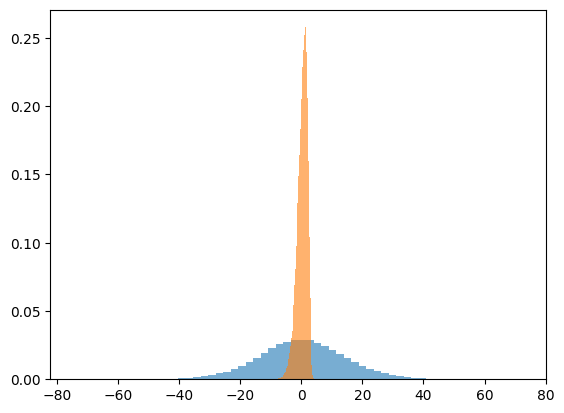

In [34]:
plt.hist(pnl_099, bins=60, alpha=0.6, label='0.99-CVaR', color='tab:blue', density=True)
plt.hist(pnl_05, bins=60, alpha=0.6, label='0.5-CVaR', color='tab:orange', density=True);

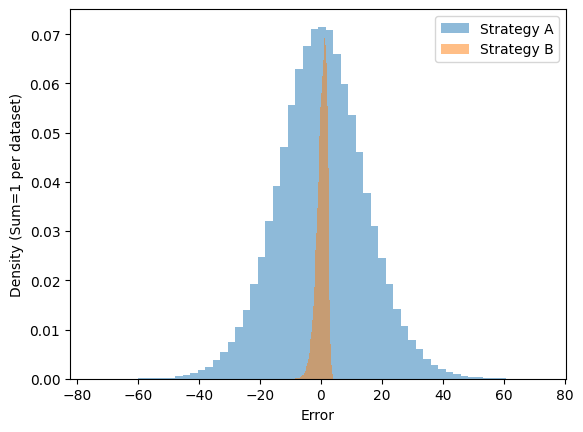

In [24]:
plt.hist(pnl_099,
         bins=60,
         weights=np.ones_like(pnl_099)/len(pnl_099),
         alpha=0.5,
         label='Strategy A')
plt.hist(pnl_05,
         bins=60,
         weights=np.ones_like(pnl_05)/len(pnl_05),
         alpha=0.5,
         label='Strategy B')
plt.xlabel('Error')
plt.ylabel('Density (Sum=1 per dataset)')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from scipy.stats import norm

# Extract stock price paths and volatility from simulation
S_numpy = S_torch.cpu().detach().numpy()  # Convert to NumPy
V_numpy = V_paths_np  # Volatility from Heston model

# Get unique s_t and v_t for meshgrid
s_t_unique = np.unique(S_numpy[:, -1])  # Last step stock prices
v_t_unique = np.unique(V_numpy[:, -1])  # Last step volatilities
S, V = np.meshgrid(s_t_unique, v_t_unique)

# Compute Network Delta (Deep Hedge)
deltas_rec_numpy = deltas_rec.cpu().detach().numpy()
deltas_rec_grid = deltas_rec_numpy.reshape(S.shape)  # Ensure shape fits

# Compute Model Delta (Black-Scholes)
def black_scholes_delta(S, K, T, sigma):
    d1 = (np.log(S/K) + 0.5*sigma**2*T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

model_delta_grid = black_scholes_delta(S, K=100, T=30/365, sigma=0.2)  # Use assumed sigma

# Compute Difference
difference_grid = deltas_rec_grid - model_delta_grid

# Plotting
fig = plt.figure(figsize=(12, 8))

# Network Delta (Deep Hedge)
ax1 = fig.add_subplot(231, projection='3d')
ax1.plot_surface(S, V, deltas_rec_grid, cmap='coolwarm')
ax1.set_title("Network Delta")

# Model Delta (Black-Scholes)
ax2 = fig.add_subplot(232, projection='3d')
ax2.plot_surface(S, V, model_delta_grid, cmap='coolwarm')
ax2.set_title("Model Delta")

# Difference
ax3 = fig.add_subplot(233, projection='3d')
ax3.plot_surface(S, V, difference_grid, cmap='coolwarm')
ax3.set_title("Difference (Network - Model)")

# Labels
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("$s_t$ (Stock Price)")
    ax.set_ylabel("$v_t$ (Volatility)")
    ax.set_zlabel("Delta")

plt.tight_layout()
plt.show()

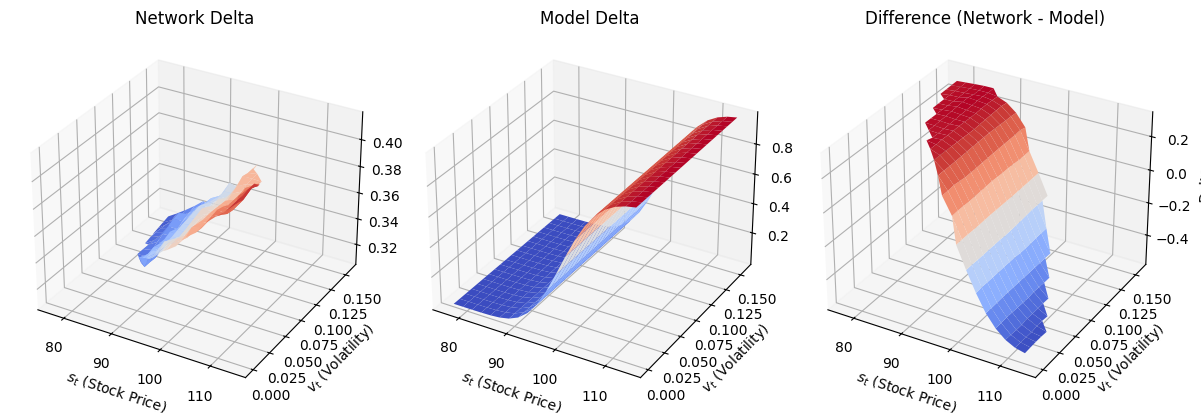

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from scipy.stats import norm

# Sample data to reduce memory usage
sample_size = 500  # Adjust based on available memory
indices = np.random.choice(S_torch.shape[0], sample_size, replace=False)

# Extract a subset of stock prices and volatilities
S_sampled = S_torch[indices, -1].cpu().detach().numpy()  # Last step stock price
V_sampled = V_paths_np[indices, -1]  # Last step volatility

# Create a small meshgrid (reducing resolution)
s_t_unique = np.linspace(S_sampled.min(), S_sampled.max(), 20)
v_t_unique = np.linspace(V_sampled.min(), V_sampled.max(), 20)
S, V = np.meshgrid(s_t_unique, v_t_unique)

# Compute Network Delta (Deep Hedge) using sampled points
deltas_rec_sampled = deltas_rec[indices, -1].cpu().detach().numpy()

# Interpolate onto a grid for smoother plotting
from scipy.interpolate import griddata
deltas_rec_grid = griddata((S_sampled, V_sampled), deltas_rec_sampled, (S, V), method='linear')

# Compute Model Delta (Black-Scholes)
def black_scholes_delta(S, K, T, sigma):
    d1 = (np.log(S/K) + 0.5*sigma**2*T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

model_delta_grid = black_scholes_delta(S, K=100, T=30/365, sigma=0.2)

# Compute Difference
difference_grid = deltas_rec_grid - model_delta_grid

# Plotting
fig = plt.figure(figsize=(12, 8))

# Network Delta (Deep Hedge)
ax1 = fig.add_subplot(231, projection='3d')
ax1.plot_surface(S, V, deltas_rec_grid, cmap='coolwarm')
ax1.set_title("Network Delta")

# Model Delta (Black-Scholes)
ax2 = fig.add_subplot(232, projection='3d')
ax2.plot_surface(S, V, model_delta_grid, cmap='coolwarm')
ax2.set_title("Model Delta")

# Difference
ax3 = fig.add_subplot(233, projection='3d')
ax3.plot_surface(S, V, difference_grid, cmap='coolwarm')
ax3.set_title("Difference (Network - Model)")

# Labels
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("$s_t$ (Stock Price)")
    ax.set_ylabel("$v_t$ (Volatility)")
    ax.set_zlabel("Delta")

plt.tight_layout()
plt.show()